In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv", index_col='Date')

In [ ]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
06/09/2023,"1,977.20","1,980.50","1,987.80","1,971.00",130.41K,-0.07%
06/08/2023,"1,978.60","1,956.20","1,985.70","1,955.20",191.84K,1.03%
06/07/2023,"1,958.40","1,980.00","1,986.50","1,955.40",189.53K,-1.17%
06/06/2023,"1,981.50","1,978.00","1,982.90","1,970.30",136.00K,0.36%
06/05/2023,"1,974.30","1,962.30","1,980.40","1,953.80",179.99K,0.24%
...,...,...,...,...,...,...
12/07/2017,"1,253.10","1,265.20","1,266.80","1,245.80",326.47K,-1.03%
12/06/2017,"1,266.10","1,268.30","1,271.80","1,264.80",253.05K,0.09%
12/05/2017,"1,264.90","1,279.10","1,279.80","1,263.20",334.83K,-1.00%



# Preprocessing Data

---





In [ ]:
# Drop column that aren't use
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()

# Flip the column
df = df.iloc[::-1]

In [ ]:
# Check if data still contain null values
df.isnull().sum()

Price    0
dtype: int64

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

In [ ]:
df

,Price
Date,
2017-12-01,1282.3
2017-12-04,1277.7
2017-12-05,1264.9
2017-12-06,1266.1
2017-12-07,1253.1
...,...
2023-06-05,1974.3
2023-06-06,1981.5
2023-06-07,1958.4


In [ ]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "Date"

# Decompose

---



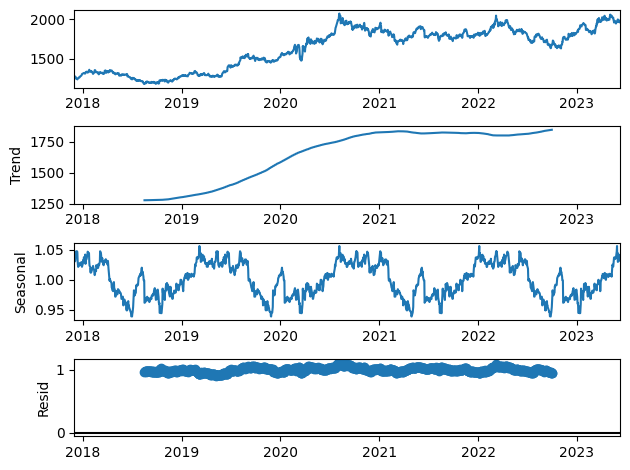

In [ ]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

# Split dataset (7-2-1)

---



In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.Price.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val.tail(len(val)))
  print('MAE: ', val_mae)

  val_value = val.Price.values
  pred_val_value = pred_val.tail(len(val)).values
  val_ape = np.abs((val_value - pred_val_value) / val_value)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val.tail(len(val)))
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
# Split data (7-2-1)
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

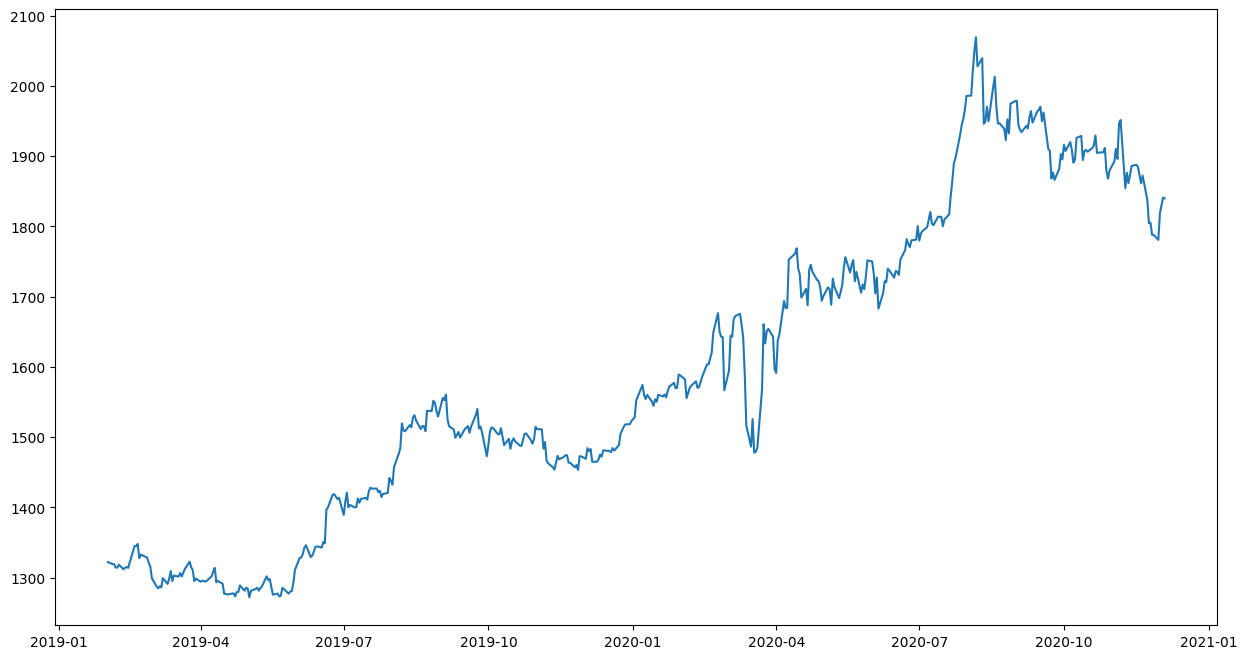

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['Price'][300:777]);

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=410, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return 

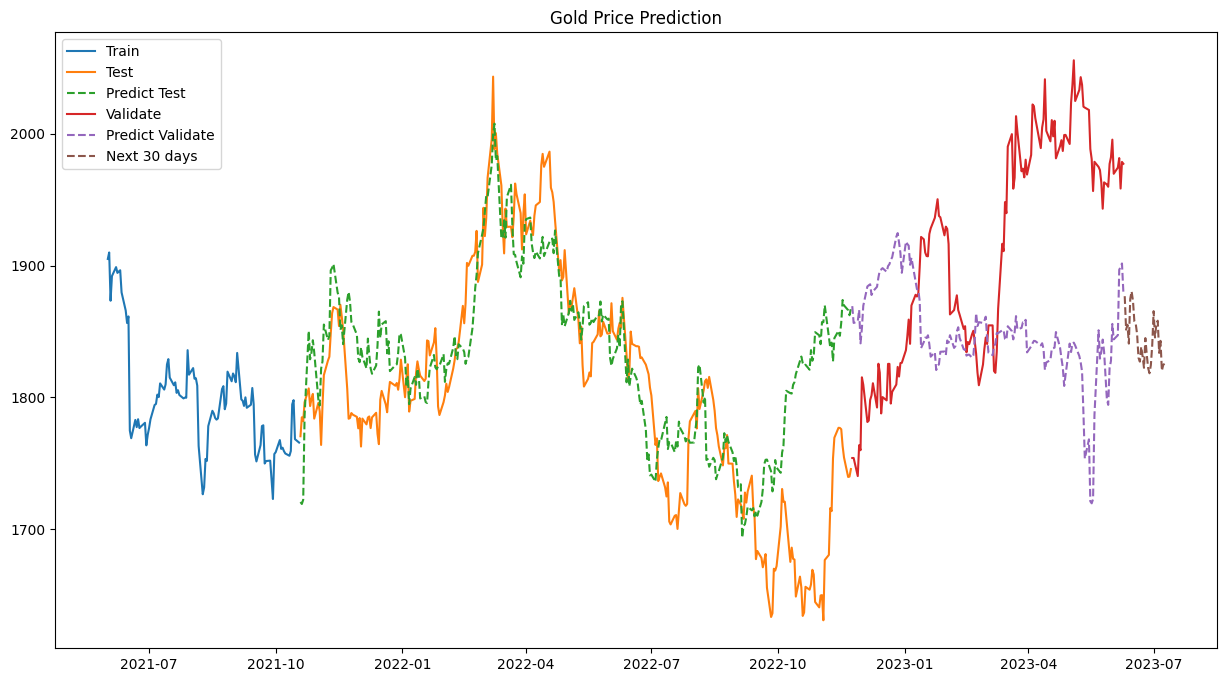

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  45.47309244405298
MAPE:  2.593867876467367
RMSE:  63.99517842592495

** Validate **
MAE:  103.81888725022017
MAPE:  5.339904673718573
RMSE:  122.19293863459856


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                 1000
Model:             ExponentialSmoothing   SSE                         142531.140
Optimized:                         True   AIC                           5789.560
Trend:                   Multiplicative   BIC                           7826.279
Seasonal:                Multiplicative   AICC                          6388.550
Seasonal Periods:                   410   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         11:06:24
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8889226                alpha                 True
smoothing_trend       

# Split dataset (6-3-1)

---

In [ ]:
# Spilit data (6-3-1)
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
# holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=380, damped_trend=True)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=351, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return 

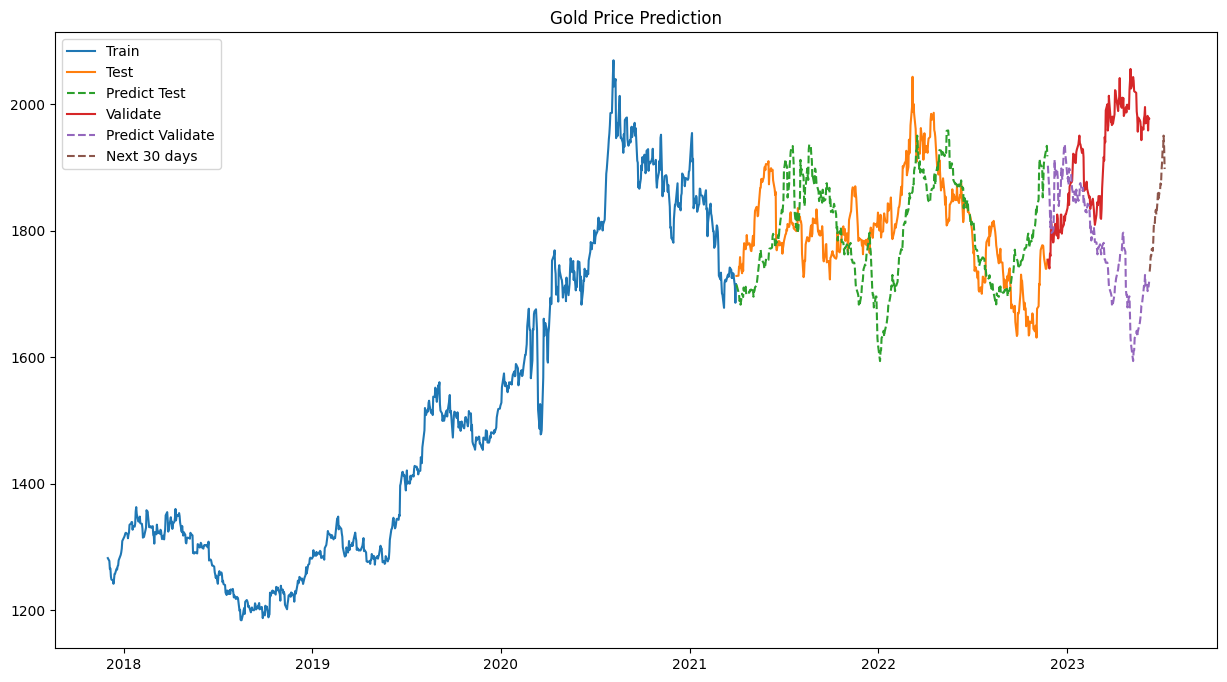

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  78.35482986788509
MAPE:  4.352865068564756
RMSE:  92.40714746898013

** Validate **
MAE:  161.66560232402523
MAPE:  8.237944126292707
RMSE:  203.62452480712915


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  858
Model:             ExponentialSmoothing   SSE                         126498.106
Optimized:                         True   AIC                           4996.319
Trend:                   Multiplicative   BIC                           6688.958
Seasonal:                Multiplicative   AICC                          5511.437
Seasonal Periods:                   351   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         11:06:41
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9596374                alpha                 True
smoothing_trend       

# Split Dataset (5-3-2)

---



In [ ]:
# Spilit data (5-3-2)
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
train

,Price
Date,
2017-12-01,1282.3
2017-12-04,1277.7
2017-12-05,1264.9
2017-12-06,1266.1
2017-12-07,1253.1
...,...
2020-09-03,1937.8
2020-09-04,1934.3
2020-09-07,1943.2


In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
# holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=380, damped_trend=True)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=293, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


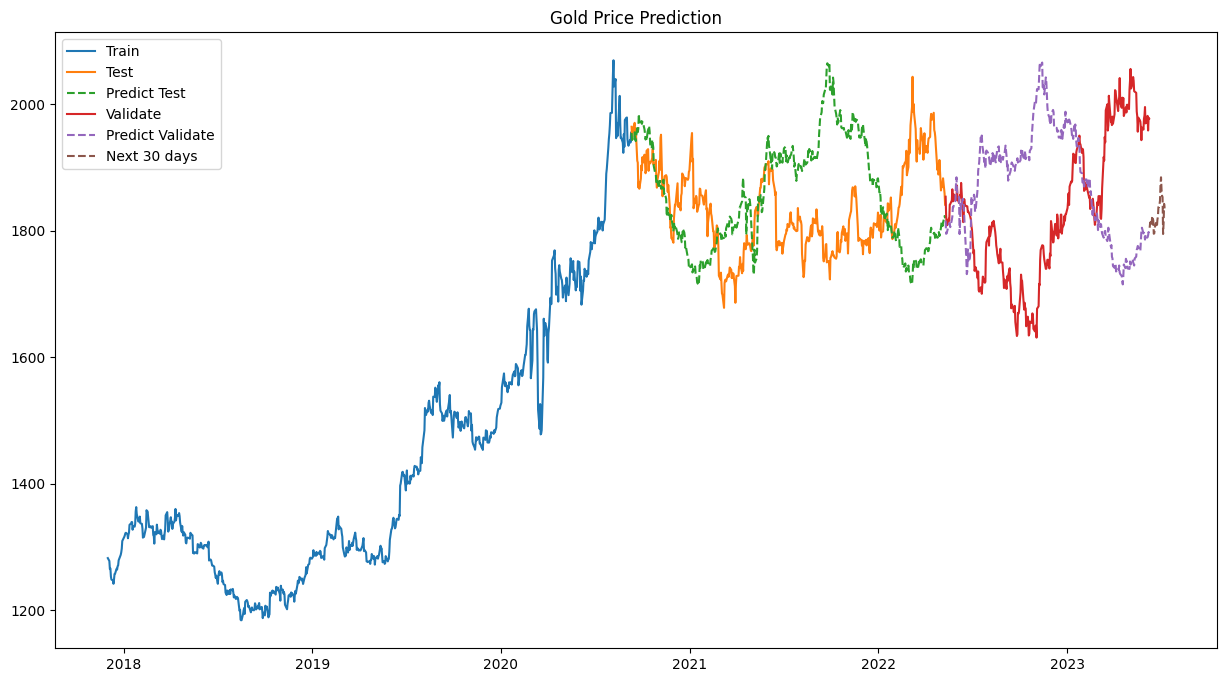

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Gold Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  101.77899796026699
MAPE:  5.5618081548601355
RMSE:  123.52249114388238

** Validate **
MAE:  155.45563838997214
MAPE:  8.578391996378722
RMSE:  183.7480786903151


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  715
Model:             ExponentialSmoothing   SSE                         101440.546
Optimized:                         True   AIC                           4138.786
Trend:                   Multiplicative   BIC                           5501.326
Seasonal:                Multiplicative   AICC                          4575.018
Seasonal Periods:                   293   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         11:06:52
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9242806                alpha                 True
smoothing_trend       

# Evaluating model

---


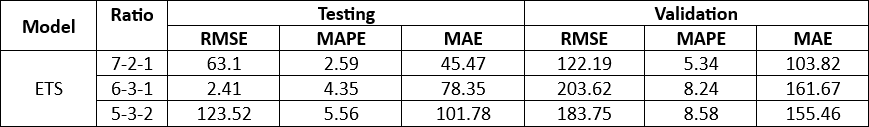